<h1>MCMC FOR NEURAL NETWORKS</h1>

**Key references**:

- _Bayesian neural networks via MCMC: a Python-based tutorial_ by Rohitash Chandra and Joshua Simmons
    - **Paper**: https://arxiv.org/pdf/2304.02595
    - **Web page**: https://ar5iv.labs.arxiv.org/html/2304.02595
    - **GitHub repository**: https://github.com/sydney-machine-learning/Bayesianneuralnetworks-MCMC-tutorial
- [_Metropolis-Hastings (MH)_ from **Markov Chain Monte Carlo (MCMC)** from **Sampling Methods** from **Bayesian Inference** from `conceptual-notes`](https://github.com/pranigopu/mastersProject/blob/main/conceptual-notes/bayesian-inference/sampling-methods/markov-chain-monte-carlo/metropolis-hastings-mh.md) (theoretical reference)

---

**Topics discussed**:

1. [Practical Introduction to MCMC](#1.-Practical-Introduction-to-MCMC)
    - Introduces MCMC as a sampling method using a simple example wherein the posterior has only one parameter
    - Uses the Metropolis-Hastings algorithm as it is the most straighforward MCMC algorithm
    - Helps give a basic idea about how MCMC would be implemented
2. [Applying MCMC to a Linear Model](#2.-Applying-MCMC-to-a-Linear-Model)
    - Introduces MCMC for a multi-parameter linear model
    - Bridges the gap between MCMC as a sampling method and MCMC as applied to neural networks
  
---


**Theoretical notation**:

- $P$, denoting the probability measure
- $\theta$, the model parameter, i.e. the parameter for the generalised model used
- $D$, the observations of the real-life process being modelled
- $p = P(\theta|D)$, the target distribution, i.e. the posterior distribution
- $P(D|\theta)$, the likelihood
- $P(\theta)$, the prior

---

# 1. Practical Introduction to MCMC
> **Key practical reference**: [`Bayesianneuralnetworks-MCMC-tutorial` / `02-Basic-MCMC.ipynb`](https://github.com/sydney-machine-learning/Bayesianneuralnetworks-MCMC-tutorial/blob/main/02-Basic-MCMC.ipynb)

---

**NOTE**: _To introduce MCMC, we shall use the Metropolis-Hastings algorithm, which is the most straighforward MCMC algorithm._

---

## Problem statement
**General problem statement**:

Sampling the posterior of a single parameter (we shall call it the "model parameter").

**Specific problem statement**:

Obtain information about the probability of success $\theta$ (which is our model parameter) given some data of $k$ successes in $n$ trials using an uninformative prior (e.g. a uniform distribution, i.e. before making observations, we assume that $\theta$ is uniformly distributed). Here, the outcomes of the real-life process being modelled are distributed by a binomial distribution with some probability of success, which is our target distribution. Note that $\theta$ is the probability of success of our model, and we try to find the target distribution by making our model as similar as possible to the real-life process. In other words, we shall solve for the posterior distribution of parameter $\theta$, and thereby find (or at least estimate) the target distribution.

**NOTE**: $\theta$ _is the model's <u>probability</u> of success, which means its uniform prior must be_ $\text{Uniform}([0, 1])$.

## Necessary imports

In [1]:
import numpy as np
from numpy import random
from tqdm import tqdm # NOTE: `tqdm` is just used to display the progress bar when looping over iterables
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

## Defining the likelihood
By Bayes' rule, we know that:

$p = P(\theta|D) \propto P(D|\theta) P(\theta)$

Our prior has already been defined as $\text{Uniform}([0, 1])$ (see the previous sections).

---

Hence, we need to define the likelihood function given our data $(k, n)$. How? Firstly, we know it must be a binomial distribution, since the likelihood is the probability that our model would generate the outcomes $D$ (generated by the real-life process), given that the model parametrised by $\theta$. Hence, the likelihood function is a function that inputs $k$ (the number of successes), $n$ (the number of trials) and $\theta$ (the probability of success) and outputs the probability mass of $(k, n)$ under $\text{Binomial}(\theta)$, i.e. the binomial distribution parametrised by $\theta$.

In [2]:
# First define our likelihood function which will be dependent on provided `data`
likelihood_function = lambda k, n, θ: stats.binom.pmf(k, n, θ)

## Setting up MCMC

In [23]:
# Basic MCMC parameters:
n_samples = 10000 # number of samples to draw from the posterior
burnin = 2500 # number of samples to discard before recording draws from the posterior

# Specifying the data, ensuring k <= n:
binom_k = 80 # Number of successes
binom_n = 100 # Number of trials

# Initial parameter value from which to start sampling (drawn from the prior):
θ_current = random.uniform(0, 1)

# Variable to keep track of the number of accepted samples:
n_accepted_samplesed_samples = 0

# Create an array of NaNs to fill with our samples:
p_posterior = np.full(n_samples, np.nan) 

## Running MCMC
Now, we shall create the MCMC loop and sample the posterior distribution. Note that:

- We use an uinformative uniform prior $\text{Uniform}([0, 1])$, where $P(\theta) = 1$ if and only if $\theta \in [0, 1]$
- We shall also use the same distribution, i.e. $\text{Uniform}([0, 1])$ as the sampling distribution

---

Now, note that the Metropolis-Hastings acceptance probability is given by the following:

$A(a \rightarrow b) = \max(1, \frac{f(a)}{f(b)} \frac{g(a|b)}{g(b|a)})$

- $f$ as the target distribution's numerator, namely $P(D|\theta) P(\theta)$ in our case
- $g$ as the sampling probability, namely $\text{Uniform}([0, 1])$ in our case
- $a$ is the current sample
- $b$ is the proposed sample

> **Reference**: [_Metropolis-Hastings (MH)_ from **Markov Chain Monte Carlo (MCMC)** from **Sampling Methods** from **Bayesian Inference** from `conceptual-notes`](https://github.com/pranigopu/mastersProject/blob/main/conceptual-notes/bayesian-inference/sampling-methods/markov-chain-monte-carlo/metropolis-hastings-mh.md)

---

Hence, in our case:

$A(\theta \rightarrow \theta')$

$= \max(1, \frac{P(D|\theta) P(\theta)}{P(D|\theta') P(\theta')} \times \frac{\text{Uniform}([0, 1])(\theta|\theta')}{\text{Uniform}([0, 1])(\theta'|\theta)})$

$= \max(1, \frac{P(D|\theta) \text{Uniform}([0, 1])(\theta)}{P(D|\theta') \text{Uniform}([0, 1])(\theta')} \times \frac{1}{1})$

$= \max(1, \frac{P(D|\theta) \times 1}{P(D|\theta') \times 1})$ (because the sampling distribution $\text{Uniform}([0, 1])$ ensures that $\theta \in [0, 1]$ and $\theta' \in [0, 1]$)

$= \max(1, \frac{P(D|\theta) \times 1}{P(D|\theta')})$

---

Therefore, in our case, we only need to compare the likelihood of the proposed and current samples.

In [24]:
print('Generating {} MCMC samples from the posterior:'.format(n_samples))
for i in tqdm(np.arange(n_samples), ncols=100):
    # Sample a value uniformly from 0 to 1 as a proposal:
    θ_proposed = random.uniform(0, 1)

    # Calculate the Metropolis-Hastings acceptance probability α based on the prior:
    prior_ratio = 1 # The contribution of prior to acceptance probability in this problem; reasoning is given above
    likelihood_ratio = likelihood_function(binom_k, binom_n, θ_proposed)/likelihood_function(binom_k, binom_n, θ_current)
    α = np.min([1, likelihood_ratio * prior_ratio]) # Acceptance probability

    # Probabilistically accepting the proposal:
    if random.uniform(0, 1) < α: # Simulates the probability of acceptance as α
        θ_current = θ_proposed # then update the current sample to the propoal for the next iteration
        n_accepted_samplesed_samples += 1 # add to the count of accepted samples

    # Store the current sample
    p_posterior[i] = θ_current

Generating 10000 MCMC samples from the posterior:


100%|███████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2117.27it/s]


## Presenting the results

### Printing the results

In [25]:
per_accept = (n_accepted_samplesed_samples/n_samples)*100
print(f'Number of accepted samples: {per_accept:.3f} %')
posterior_mean = np.mean(p_posterior[burnin:])
print(f'Mean value of the estimated posterior (excluding burn-in): {posterior_mean:.3f}')

Number of accepted samples: 12.750 %
Mean value of the estimated posterior (excluding burn-in): 0.797


### Plotting the posterior
In our case, we can analytically obtain the true posterior distribution $p = P(\theta|D)$, which helps compare the sampled posterior distribution to the true posterior distribution (note that in practice, obtaining the true posterior analytically can be difficult or even impossible). For reference, the mathematical derivation of the true posterior's expression is given after the following code block.

**KEY POINT**: _I have not given the true posterior's mathematical derivation before the sampling process because the true posterior's exact mathematical form is obviously irrelevant in the application of MCMC, since the purpose of MCMC in practice is to estimate a posterior distribution that cannot be obtained analytically; if it could, no estimation would be necessary. However, in our toy example, since the posterior distribution can in fact be obtained analytically, we use it merely to demonstrate the efficacy of MCMC. Hence, while the true posterior's mathematical derivation helps understand how we have compared the true posterior with the estimated (i.e. sampled) posterior in the code below, such comparison is not relevant (and, in practice, generally not possible) in the application of MCMC as such, and thus, grasping the mathematical derivation of the true posterior is not necessary to understand MCMC sampling._

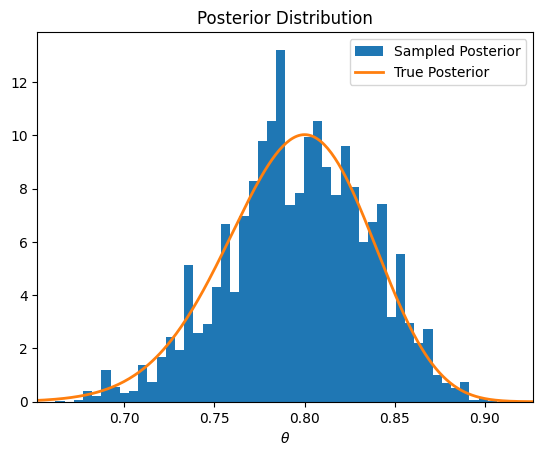

In [45]:
# DATA SETUP

# Defining the points to be plotted:
pos_points = p_posterior # Estimated posterior
H = np.linspace(0, 1, 1000) # The range of possible values for θ, for which the true posterior will be calculated
true_posterior = (binom_n+1)*likelihood_function(binom_k, binom_n, H).T # True posterior
# NOTE: Mathematical derivation for the true posterior is given below the plot

# Remove burn-in samples, if any:
if not burnin is None:
    plot_points = pos_points[burnin:, ...]
else:
    plot_points = pos_points

#================================================
# PLOTTING

plt.hist(plot_points, bins=50, density=True, label='Sampled Posterior')
plt.plot(H, true_posterior, linewidth=2, color='C1', label='True Posterior')
plt.title('Posterior Distribution')
plt.xlabel('$\\theta$')
plt.xlim([min(plot_points)-0.01, max(plot_points)+0.01])
plt.legend()
plt.show()

**Mathematical derivation of the true posterior**:

**NOTE**: _As mentioned before, this derivation is not necessary to understand MCMC sampling._

We know that the true posterior $p$ is such that $p = P(\theta|D) \propto P(D|\theta) P(\theta)$. Now, consider the fact that the parameter to be estimated is a probability value, which means all its possible values lie in the range $[0, 1]$. THerefore, in our case, since the prior is $\text{Uniform}([0, 1])$, we have that $P(\theta) = \text{Uniform}([0, 1])(\theta) = 1 \text{ } \forall \theta$, since all $\theta \in [0, 1]$. Hence, in our case, the true posterior $p$ is such that $p = P(\theta|D) \propto P(D|\theta)$, i.e. the likelihood is proportional to the true posterior.

---

Now, note that the posterior in general is given by:

$P(\theta|D) = \frac{P(D|\theta) P(\theta)}{\int_{\theta \in \Theta} P(D|\theta) d\theta}$, where $\Theta$ is the hypothesis space

In our case, we have the following:

- Hypothesis space is $[0, 1]$, since $\forall \theta, \theta \in [0, 1]$
- $P(\theta) = \text{Uniform}([0, 1])(\theta) = 1$, since $\forall \theta, \theta \in [0, 1]$
- $D = (n, k)$, where $n =$ total number of trials and $k =$ total number of successes
- Hence, $P(D|\theta) = P(n, k|\theta) = \text{Binomial}(n, k, \theta)$

Hence, the posterior in our case is given by:

$P(\theta|D) = \frac{P(D|\theta)}{\int_0^1 \text{Binomial}(n, k, \theta) d \theta} = \frac{P(D|\theta)}{\int_0^1 \frac{n!}{(n-k)!k!} \theta^k (1-\theta)^{n-k} d\theta}$ >> \[**checkpoint 1**\]

---

Let us focus on the denominator:

$\int_0^1 \frac{n!}{(n-k)!k!} \theta^k (1-\theta)^{n-k} d\theta$

$= \frac{n!}{(n-k)!k!} \int_0^1 \theta^k (1-\theta)^{n-k} d\theta$ >> \[**checkpoint 2**\]

Let us focus on the integral alone:

$\int_0^1 \theta^k (1-\theta)^{n-k} d\theta$

= $[-\theta^k \frac{(1-\theta)^{n-k+1}}{n-k+1} - \int_0^1 k\theta^{k-1} (-\frac{(1-\theta)^{n-k+1}}{n-k+1}) d\theta]_0^1$ (using [integration by parts](https://byjus.com/maths/integration-by-parts/))

= $[-\theta^k \frac{(1-\theta)^{n-k+1}}{n-k+1} + \frac{k}{n-k+1} \int_0^1 \theta^{k-1} (1-\theta)^{n-k+1} d\theta]_0^1$

= $[\frac{1}{n-k+1} (-\theta^k (1-\theta)^{n-k+1} + k \int_0^1 \theta^{k-1} (1-\theta)^{n-k+1} d\theta)]_0^1$

Using integration by parts in the same way repeatedly on the above expression, we get:

$[\frac{1}{n-k+1} (-\theta^k (1-\theta)^{n-k+1} + \frac{k}{n-k+2}(-\theta^{k-1} (1-\theta)^{n-k+2} + \frac{k-1}{n-k+3}( ... \frac{(k-(k+1))}{n-k+(k+1)}(-\theta^{k-k} (1-\theta)^{n-k+(k+1)} + (k-k))) ... ))]_0^1$

$= [\frac{1}{n-k+1} (-\theta^k (1-\theta)^{n-k+1} + \frac{k}{n-k+2}(-\theta^{k-1} (1-\theta)^{n-k+2} + \frac{k-1}{n-k+3}( ... \frac{1}{n+1}(-\theta^{0} (1-\theta)^{n+1} + 0)) ... ))]_0^1$

$= [\frac{1}{n-k+1} (-\theta^k (1-\theta)^{n-k+1} + \frac{k}{n-k+2}(-\theta^{k-1} (1-\theta)^{n-k+2} + \frac{k-1}{n-k+3}( ... \frac{1}{n+1}(-1 \cdot (1-\theta)^{n+1})) ... ))]_0^1$ >> [**checkpoint 3**\]

---

When we put $\theta = 1$, _expression within square braces in_ \[**checkpoint 3**\] $= 0$

When we put $\theta = 0$, _expression within square braces in_ \[**checkpoint 3**\] $= -\frac{k!}{(n-k+1)(n-k+2) ...  (n+1)} = -\frac{k!}{\frac{(n+1)!}{(n-k)!}} = -\frac{(n-k)!k!}{(n+1)!}$

Therefore, _expression in_ \[**checkpoint 3**\] $= 0 - (-\frac{(n-k)!k!}{(n+1)!}) = \frac{(n-k)!k!}{(n+1)!}$

---

Therefore, putting the above result to the denominator term given in \[**checkpoint 2**\]:

$\frac{n!}{(n-k)!k!} \int_0^1 \theta^k (1-\theta)^{n-k} d\theta = \frac{n!}{(n-k)!k!} \frac{(n-k)!k!}{(n+1)!} = \frac{1}{n+1}$

---

Therefore, putting the above result to the posterior term given in \[**checkpoint 1**\]:

$P(\theta|D)= \frac{P(D|\theta)}{\frac{1}{(n+1)}} = (n+1) P(D|\theta)$

This is why, in my code, to obtain the true posterior for `np.linspace(0, 1, 1000)`, I have used the following expression:

```
(binom_n+1)*likelihood_function(binom_k, binom_n, np.linspace(0, 1, 1000))
```

### Plotting the sample values across sampling iterations

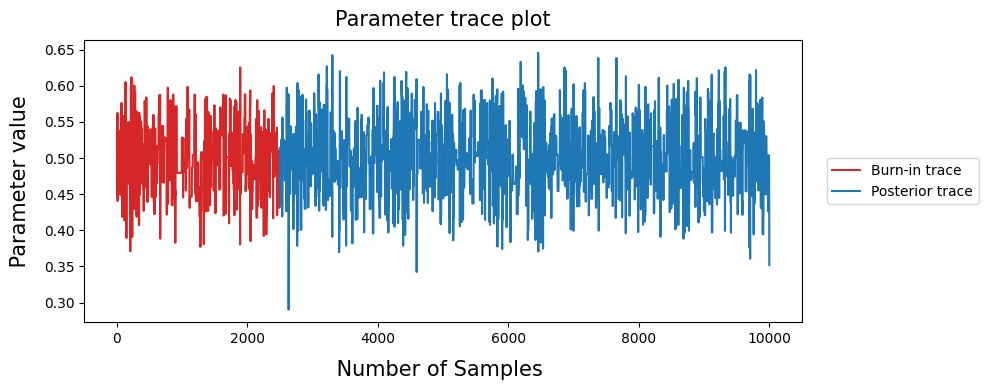

In [8]:
# Setting up the plot:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(111)

# Identify and separate burn-in samples, if any:
if not burnin is None:
    ax1.plot(np.arange(burnin), pos_points[:burnin], color='C3',label='Burn-in trace')
    ax1.plot(np.arange(burnin,pos_points.shape[0]), pos_points[burnin:], color='C0',label='Posterior trace')
else:
    ax1.plot(pos_points,label='Posterior trace')

# Plot burn-in and trace samples:
lgd = plt.legend(loc='center left',bbox_to_anchor=(1.025,0.5))
plt.title("Parameter trace plot", fontsize = fontsize, pad=10)
plt.xlabel(' Number of Samples  ', fontsize = fontsize, labelpad=10)
plt.ylabel(' Parameter value ', fontsize = fontsize, labelpad=10)
plt.tight_layout()
plt.show()

# 2. Applying MCMC to a Linear Model
> **Key practical reference**: [`Bayesianneuralnetworks-MCMC-tutorial` / `03-Linear-Model.ipynb`](https://github.com/sydney-machine-learning/Bayesianneuralnetworks-MCMC-tutorial/blob/main/03-Linear-Model.ipynb)

## Problem statement
Here, we are dealing with a problem of the following form:

- Vector of input values $x$ (each element belonging to a particular independent variable)
- Target value $y$ (belonging to a dependent variable defined in terms of $x$)
- A linear function $f$ defined on $x$ with weights and biases stored in parameter vector $\theta$, such that $y \approx f(x, \theta)$
- An random error term to account for the fact that $f(x, \theta)$ only approximates $y$

**NOTE**: $x = (x_1, x_2 ... x_k)$, _where each of_ $x_1, x_2 ... x_k$ _is a value of a particular [covariate](https://www.statology.org/covariate/)._

---

Hence, we have that:

$y = f(x, \theta) + \epsilon$

---

Since $f$ here is defined as a linear function, we have that:

$y = wx^T + b + \epsilon = w_1 x_1 + w_2 x_2 + ... w_k x_k + b + \epsilon$, where:

- $w$ is the row vector of weights, i.e. $w = (w_1, w_2 ... w_k)$
- $x$ is the row vector of inputs, i.e. $x = (x_1, x_2 ... x_k)$
- $y$ is the output, i.e. the target variable's value
- $b$ is the bias term (a single value)
- Hence, the parameter vector is given by $\theta = (w_1, w_2 ... w_k, b)$

---

Our goal is to estimate the posterior distribution of $\theta = (w_1, w_2 ... w_k, b)$ using MCMC sampling.

## Necessary imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed, widgets
from types import MethodType

# Visulisation functions:
from visualisations import histogram_trace, plot_linear_data, plot_y_timeseries, boxplot_weights, plot_ycorr_scatter
'''
`visualisations.py` is a copy of the file:
https://github.com/sydney-machine-learning/Bayesianneuralnetworks-MCMC-tutorial/blob/main/functions/visualisations.py
'''

np.random.seed(2023)

## Defining the linear model
Simple linear model with a single output $\hat{y}$ (i.e. predicted output, such that $\hat{y} \approx y$) given the covariate values $x_1, x_2 ... x_k$ of the form:

$\hat{y} = w_1 x_1 + w_2 x_2 + ... + w_k x_k + b$, where:

- $k$ = number of features
- $w = (w_1, w_2 ... w_k)$ are the weights
- $b$ is the bias

In [3]:
class LinearModel:
    # Initialise values of the model parameters:
    def __init__(self):
        self.w = None
        self.b = None 

    # Function to take in the data and the proposed sample of the parameter and return the prediction:
    def evaluate_proposal(self, D, θ):
        '''
        Encode the proposed parameters and then use the model to predict
        ------------------------------------
        D : (n x k) array of data, i.e. n data points with k covariate values (input values) each
        θ : (k + 1) vector of model parameters; the last element of θ is the bias term

        NOTE: Although θ is a vector of parameters, as a vector, it is collectively regarded as one parameter.
        '''

        # Method to encode w and b, i.e. to parametrise the model with w and b:
        self.encode(θ) # NOTE: θ = (w_1, w_2 ... w_k, b)
        prediction = self.predict(D) # Predict based on the newly parametrised model
        return prediction

    # Linear model prediction:
    def predict(self, x):
        y_hat = x.dot(self.w) + self.b
        return y_hat
    
    # Helper function to split the parameter vector θ ("θ") into w and b and assign them to the model:
    def encode(self, θ):
        self.w =  θ[0:-1]
        self.b = θ[-1] 

## Defining the approach for MCMC sampling
We assume the error term $\epsilon$ in $y = wx^T + b + \epsilon$ is a random normal variable centered at zero, with variance $\tau^2$:

$\epsilon \sim \text{Normal}(0, \tau^2)$

As a result, since $\theta$ is meant to be fixed once obtained, and since $x = (x_1, x_2 ... x_k)$ is a vector of covariates for which no distribution is considered, then we have that the target variable $y$ is also distributed by a normal distribution; naturally, its variance is the same as the variance for the error term. More precisely, for every given vector of inputs and given parameterisation, the target value is normally distributed with mean $wx^T + b = \hat{y}$ and variance $\tau^2$:

$y \sim \text{Normal}(wx^T + b, \tau^2)$

---

Hence, both $\theta$ and $\tau^2$ are unknown parameters that together are relevant to modelling $y$.

$\implies$ We have to estimate the posterior distribution not only of $\theta$ but also of $\tau^2$.

$\implies$ $(\theta, \tau^2)$ together constitute a combined parameter distributed by a joint posterior.

**NOTE**: _When referring to "model parameter", I am referring only to_ $\theta$; _to refer to_ $(\theta, \tau^2)$, _I shall say "combined parameter"._

### Defining the likelihood

We have shown that, given $\epsilon \sim \text{Normal}(0, \tau^2)$, $y$ us distributed as follows:

$y \sim \text{Normal}(wx^T + b, \tau^2)$

Hence, the likelihood _density_ of getting $y$ given input $x$ and parameterisation $\theta$ is given by:

$\text{Normal}(wx^T + b, \tau^2)(y)$

$= \frac{1}{\sqrt{2 \pi \tau^2}} e^{- \frac{(y - (wx^T + b))^2}{2 \tau^2}}$ (probability density function of normal distribution)

$= \frac{1}{\sqrt{2 \pi \tau^2}} e^{- \frac{(y - \hat{y})^2}{2 \tau^2}}$ (since $\hat{y} = wx^T + b$)

**NOTE**: _We can only use density, because_ $y$ _is distributed across a continuous range, which means point-wise probability mass is always 0._

---

In practice, we obtain a set of $n$ observed $y$ values, $D_y = (y_1, y_2 ... y_n)$, rather than a continuous range.

---

The likelihood _density_ of getting $D_y = (y_1, y_2 ... y_n)$ is given by:

$\displaystyle \prod_{i=1}^n \frac{1}{\sqrt{2 \pi \tau^2}} e^{- \frac{(y_i - \hat{y_i})^2}{2 \tau^2}}$

The above product is computationally intensive; hence we use the log-likelihood density:

$\displaystyle \log(\prod_{i=1}^n \frac{1}{\sqrt{2 \pi \tau^2}} e^{- \frac{(y_i - \hat{y_i})^2}{2 \tau^2}})$

$= \displaystyle \sum_{i=1}^n \log(\frac{1}{\sqrt{2 \pi \tau^2}} e^{- \frac{(y_i - \hat{y_i})^2}{2 \tau^2}})$

$= \displaystyle \sum_{i=1}^n \log \frac{1}{\sqrt{2 \pi \tau^2}} + \log e^{- \frac{(y_i - \hat{y_i})^2}{2 \tau^2}})$

$= \displaystyle \sum_{i=1}^n \log \frac{1}{\sqrt{2 \pi \tau^2}} - \frac{(y_i - \hat{y_i})^2}{2 \tau^2}$

$= \displaystyle \sum_{i=1}^n \log ((2 \pi \tau^2)^{- \frac{1}{2}}) - \frac{(y_i - \hat{y_i})^2}{2 \tau^2}$

$= \displaystyle \sum_{i=1}^n - \frac{1}{2} \log (2 \pi \tau^2) - \frac{(y_i - \hat{y_i})^2}{2 \tau^2}$

$= \displaystyle \sum_{i=1}^n - 0.5 \log (2 \pi \tau^2) - 0.5 \frac{(y_i - \hat{y_i})^2}{\tau^2}$

In [4]:
def likelihood_function(self, θ, τ_squared, test=False): # The `self` is given since we shall make this function a class method later
    '''
    Calculate the likelihood of the data given the parameters
    ------------------------------------
    INPUT
    θ         : (k + 1) vector of parameters; the last element of θ is the bias term
    τ_squared : Variance of the error term
    test      : Boolean which indicates whether to use testing data (True) or training data (False)
    ------------------------------------
    OUTPUT
    log_likelihood   : log likelihood of the data given the parameters
    model_prediction : prediction of the model given the parameters
    accuracy         : accuracy (RMSE) of the model given the parameters
    '''

    # Deciding whether to use testing data or training data:
    if test:
        x_data = self.x_test
        y_data = self.y_test
    else:
        x_data = self.x_data
        y_data = self.y_data
    
    # First make a prediction with parameters θ:
    model_prediction = self.model.evaluate_proposal(x_data, θ) # = f(x, θ), i.e. output of the linear model parametrised by θ, without error
    model_simulation = model_prediction + np.random.normal(0, τ_squared, size=model_prediction.shape) # = f(x, θ) + error
    # NOTE: `model_simulation` is not necessary for sampling itself, but is useful for reporting on the sampling process
    accuracy = self.rmse(model_prediction, y_data) # RMSE error metric, useful for reporting
    
    # Now calculate the log likelihood:
    log_likelihood = np.sum(-0.5*np.log(2*np.pi*τ_squared) - 0.5*np.square(y_data - model_prediction)/τ_squared)
    return [log_likelihood, model_prediction, model_simulation, accuracy]

**PRACTICAL NOTES**:

**1. The vital role of model prediction**

The model prediction is vital for the following:

- Calculating the likelihood value (necessary for posterior sampling)
- Calculating the model's accuracy (useful for reporting about the model after the sampling is done)

---

**2. What are the values not relevant to sampling but useful for reporting purposes afterward?**

- `model_simulation`
- `accuracy`

---

**3. Why bother with storing simulated outputs of the model?**

The simulated output (i.e. simulated target value) of the model is $f(x, \theta) + \epsilon$, i.e. it is the output generated by the model parametrised by some parameter $\theta$. In our case, the model is a linear model with a probabilistic element, namely the error term. Now, note that the simulated outputs give us an idea about the well (or not well) the model simulates the observed outputs (i.e. observed target values), and hence, they give us an idea about how well (or not well) the model actually models the real-life process generating the observed outputs. _This is not relevant for the likelihood or the sampling process as such, but it is simply useful data to report on the sampling process after it is done._

### Defining the prior
We have shown that, given $\epsilon \sim \text{Normal}(0, \tau^2)$, $y$ us distributed as follows:

$y \sim \text{Normal}(wx^T + b, \tau^2)$

---

Hence, note that we have to estimate the posterior distribution not only of $\theta$ but also of $\tau^2$, since both are unknown parameters that together are relevant to modelling $y$. Hence, ($\theta, \tau^2)$ is a combined parameter with a prior distribution that combines the priors of $\theta$ and $\tau^2$. We shall define the priors as follows:

- $\theta \sim \text{Normal}(0, \sigma^2 I)$ (here, $I$ denotes the $k \times k$ identity matrix)
- $\tau^2 \sim \Gamma^{-1}(c_1, c_2)$ (inverse-gamma distribution with $c_1, c_2$ as its parameters)

In [5]:
# Define the prior
def prior(self, σ_squared, c_1, c_2, θ, τ_squared): # The `self` is given since we shall make this function a class method later
    '''
    Calculate the prior of the parameters
    ------------------------------------
    INPUT
    σ_squared : Variance of normal prior for θ
    c_1       : Parameter c_1 of the inverse gamma prior for τ^2
    c_2       : Parameter c_2 of the inverse gamma prior for τ^2
    θ         : (k + 1) vector of parameters; the last element of θ is the bias term
    τ_squared : Variance of the error term
    ------------------------------------
    OUTPUT
    log_prior : log prior
    '''
    
    n_params = self.θ_size # number of parameters in model
    part1 = -1*(n_params/2)*np.log(σ_squared)
    part2 = 1/(2*σ_squared)*(sum(np.square(θ)))
    log_prior = part1 - part2 - (1 + c_1)*np.log(τ_squared) - (c_2/τ_squared)
    return log_prior

### Defining the sampler

In [ ]:
def sampler(self): # The `self` is given since we shall make this function a class method later
    '''
    Run the sampler for a defined linear model
    '''
    #------------------------------------
    # INITIALISING ARRAYS TO STORE SAMPLED POSTERIOR VALUES

    # 1. Posterior of all weights and bias over all samples
    pos_θ = np.ones((self.n_samples, self.θ_size)) 
    
    # 2. Posterior defining the variance of the noise in predictions:
    pos_τ = np.ones((self.n_samples, 1))
    pos_eta = np.ones((self.n_samples, 1))

    #------------------------------------
    # INITIALISING ARRAYS TO STORE OUTPUTS FOR SIMULATED TRAINING AND TESTING DATA
    '''
    NOTE:
    - These data are not relevant for posterior sampling as such
    - But they are useful for reporting about the sampling
    - See the practical notes below this code block for more
    '''
    
    # Record output (i.e. predicted target value) f(x, θ) over all samples:
    pred_y = np.zeros((self.n_samples, self.x_data.shape[0]))
    
    # Record simulated values f(x, θ) + error over all samples:
    sim_y = np.zeros((self.n_samples, self.x_data.shape[0]))
    
    # Record the RMSE of each sample:
    rmse_data = np.zeros(self.n_samples)
    
    # Now for test:
    test_pred_y = np.ones((self.n_samples, self.x_test.shape[0]))
    test_sim_y = np.ones((self.n_samples, self.x_test.shape[0]))
    test_rmse_data = np.zeros(self.n_samples)

    #------------------------------------
    # INITIALISING MCMC
    
    # Initialise current θ, i.e. the currently chosen vector of the model parameters:
    θ_current = np.random.randn(self.θ_size)
    
    # Make initial prediction:
    pred_y[0,] = self.model.evaluate_proposal(self.x_data, θ_current)

    # Initialise eta (we sample eta as a Gaussian random walk in the log space of τ^2):
    eta = np.log(np.var(pred_y[0,] - self.y_data))
    τ_squared_proposal = np.exp(eta)

    # Calculate the prior:
    prior_val = self.prior(self.σ_squared, self.c_1, self.c_2, θ_current, τ_squared_proposal)
    
    # Calculate the log-likelihood considering observations:
    [likelihood_current, pred_y[0,], sim_y[0,], rmse_data[0]] = self.likelihood_function(θ_current, τ_squared_proposal)

    # Variable to keep track of the number of proposed samples that have been accepted:
    n_accepted_samples = 0
    
    #------------------------------------
    # RUN THE MCMC SAMPLER FOR `n_samples` ITERATIONS
    
    for i in np.arange(1,self.n_samples):
        # Sample new values for θ and τ using a Gaussian random walk:
        θ_proposal = θ_current + np.random.normal(0, self.step_θ, self.θ_size)
        eta_proposal = eta + np.random.normal(0, self.step_eta, 1) # sample τ^2 in log space
        τ_squared_proposal = np.exp(eta_proposal)

        #________________________
        # Calculate the prior:
        prior_proposal = self.prior(self.σ_squared, self.c_1, self.c_2, θ_proposal, τ_squared_proposal)
        
        # Calculate the log-likelihood considering training data:
        [likelihood_proposal, pred_y[i,], sim_y[i,], rmse_data[i]] = self.likelihood_function(θ_proposal, τ_squared_proposal)

         # Calculate the log-likelihood considering testing data:
        [_, test_pred_y[i,], test_sim_y[i,], test_rmse_data[i]] = self.likelihood_function(θ_proposal, τ_squared_proposal, test=True)

        #________________________
        # Noting that `likelihood_function` and `prior_val` return log likelihoods, we can use log laws to calculate the acceptance probability:
        diff_likelihood = likelihood_proposal - likelihood_current
        diff_prior = prior_proposal - prior_val

        # Logarithmic version of the Metropolis-Hastings acceptance criterion:
        # NOTE: Logarithm is used since it is easier to compute if `diff_likelihood + diff_prior` happens to be large
        log_mh_prob = min(np.log(1), diff_likelihood + diff_prior)
        
        #________________________
        # Sample to accept or reject the proposal according to the acceptance probability:
        if np.random.uniform(0, 1) < np.exp(log_mh_prob):
            # Accept and update the values:
            n_accepted_samples += 1
            likelihood_current = likelihood_proposal
            prior_val = prior_proposal
            θ_current = θ_proposal
            eta = eta_proposal
            # Store to make up the posterior:
            pos_θ[i,] = θ_proposal
            pos_τ[i,] = τ_squared_proposal
            pos_eta[i,] = eta_proposal
        else:
            # Reject move and store the old values:
            pos_θ[i,] = pos_θ[i-1,]
            pos_τ[i,] = pos_τ[i-1,]
            pos_eta[i,] = pos_eta[i-1,]

    #------------------------------------
    # Calculate the acceptance rate as a check:
    accept_rate = (n_accepted_samples/self.n_samples)*100
    print('{:.3f}% were accepted'.format(accept_rate))

    # Store the posterior samples (after burn-in) in a Pandas dataframe and return:
    self.pos_θ = pos_θ[self.n_burnin:, ]
    self.pos_τ = pos_τ[self.n_burnin:, ] 
    self.pos_eta = pos_eta[self.n_burnin:, ]
    self.rmse_data = rmse_data[self.n_burnin:]

    # Split θ into w and b:
    results_dict = {'w{}'.format(_): self.pos_θ[:, _].squeeze() for _ in range(self.θ_size-1)}
    results_dict['b'] = self.pos_θ[:, -1].squeeze()
    results_dict['τ'] = self.pos_τ.squeeze()
    results_dict['rmse'] = self.rmse_data.squeeze()

    #------------------------------------
    # Return the predictions (for reporting purposes):
    pred_dict = {}
    pred_dict['train_pred'] = pred_y[self.n_burnin:,:]
    pred_dict['train_sim'] = sim_y[self.n_burnin:,:]
    pred_dict['test_pred'] = test_pred_y[self.n_burnin:,:]
    pred_dict['test_sim'] = test_sim_y[self.n_burnin:,:]

    #------------------------------------
    # Returning the overall results:
    results_df = pd.DataFrame.from_dict(results_dict)
    return results_df, pred_dict

**PRACTICAL NOTES**:

**Storing predicted and simulated outputs per sample**:

The predicted outputs consist of the linear model's predictions as parametrised by each proposed sample (i.e. the proposed values for the weights and bias of the linear model). The predicted outputs are necessary for calculating the likelihood, but once the likelihood is calculated, their role in the posterior sampling is finished; hence, storing them is relevant as useful data about the sampling process. On the other hand, simulated outputs are not relevant for posterior sampling as such, but they are stored as useful data about the sampling process.

**NOTE**: _We are storing predictions and simulations across all posterior sample proposals, not just the accepted ones. The predictions of the final model would be based on the accepted weights and biases gathered, not these stored predictions._

## Defining the class for performing MCMC

In [7]:
class MCMC:
    def __init__(self, n_samples, n_burnin, x_data, y_data, x_test, y_test):
        self.n_samples = n_samples # number of MCMC samples
        self.n_burnin = n_burnin # number of burn-in samples
        self.x_data = x_data # (n x k)
        self.y_data = y_data # (k x 1)
        self.x_test = x_test # (kt x num_features)
        self.y_test = y_test # (kt x 1)

        #------------------------------------
        # MCMC sampler hyperparameters (defines the variance term in our Gaussian random walk):
        self.step_θ = 0.02;  
        self.step_eta = 0.01; # note eta is used as tau in the sampler to consider log scale.  
        
        # Model hyperparameters (considered by looking at distribution of similar trained  models, i.e distribution of weights and bias):
        self.σ_squared = 5
        self.c_1 = 1
        self.c_2 = 0.5

        #------------------------------------
        # Initisalise the linear model class:
        self.model = LinearModel()
        self.θ_size = x_data.shape[1] + 1 # weights for each feature and a bias term (M+1)

        #------------------------------------
        # Variables to store output:
        self.pos_θ = None
        self.pos_τ = None
        self.pos_eta = None
        self.rmse_data = None
        
        #------------------------------------
        # Functions defined previously; this is poor practice, but done for readability and clarity:
        self.likelihood_function = MethodType(likelihood_function, self)
        self.prior = MethodType(prior, self)
        self.sampler = MethodType(sampler, self)
    
    #================================================
    # Additional error metric:
    def rmse(self, predictions, targets):
        return np.sqrt(((predictions - targets)**2).mean())

## Defining a synthetic regression problem

In [8]:
import import_ipynb
N = import_ipynb.NotebookLoader(path=['.'])
N.load_module('synthetic_regression_problems')
from synthetic_regression_problems import *

importing Jupyter notebook from .\synthetic_regression_problems.ipynb


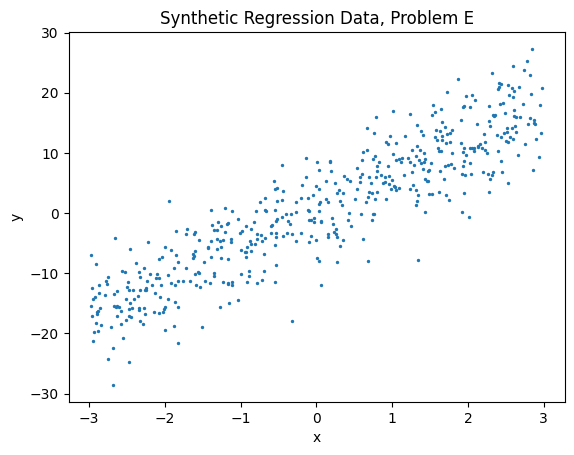

In [81]:
# MCMC Settings and Setup
n_data_points = 500
test_split = int(n_data_points * 0.8)
E = Problem_E(n_data_points)
E.plot_data()

## Running the MCMC for the synthetic regression problem

Creating testing and training data and obtaining posterior samples...

In [115]:
n_samples = 5000 # Number of samples to draw from the posterior
burnin = int(n_samples* 0.25) # Number of samples to discard before recording draws from the posterior

# or load from sunspot data
x_data = E.x[:test_split].numpy()
y_data = E.y[:test_split].numpy()
x_test = E.x[test_split:].numpy()
y_test = E.y[test_split:].numpy()

# Initialise the MCMC class:
mcmc = MCMC(n_samples, burnin, x_data, y_data, x_test, y_test)

# Run the sampler:
results, pred = mcmc.sampler()

26.360% were accepted


### Viewing the results
Note that in our example, we have only one independent variable, hence only one weight $w_0$.

In [116]:
print(results)

            w0         b           τ       rmse
0    -0.010878  0.933849  127.858626  11.299519
1     0.010175  0.936932  127.773327  11.299421
2     0.010175  0.936932  127.773327  11.299536
3    -0.017443  0.910235  127.821609  11.299407
4    -0.017443  0.910235  127.821609  11.299391
...        ...       ...         ...        ...
3745 -0.003554  0.916377  127.175626  11.299402
3746 -0.003554  0.916377  127.175626  11.299475
3747 -0.003554  0.916377  127.175626  11.299567
3748 -0.003554  0.916377  127.175626  11.299692
3749 -0.003554  0.916377  127.175626  11.299571

[3750 rows x 4 columns]


### Distribution of the model parameters

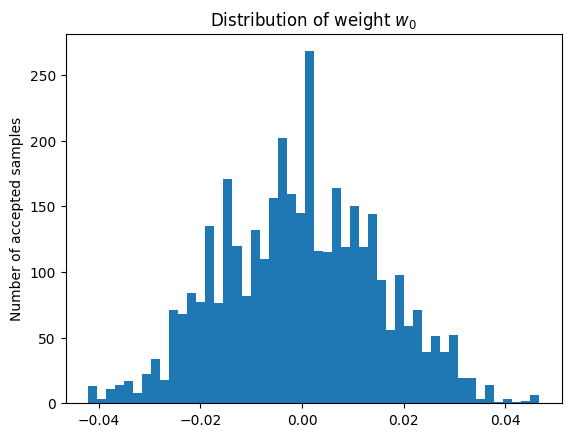

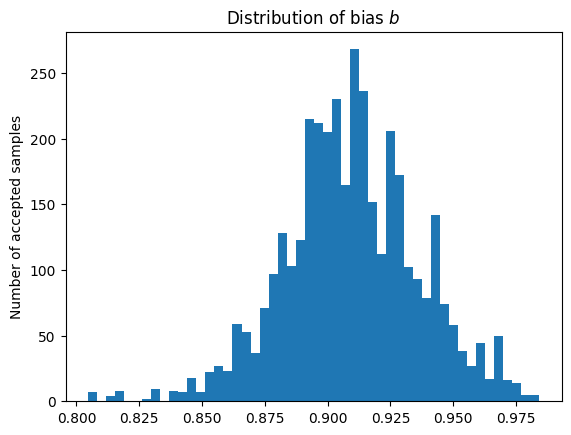

In [135]:
plt.hist(mcmc.pos_θ[:, 0], bins=50)
plt.title('Distribution of weight $w_0$')
plt.ylabel('Number of accepted samples')
plt.show()

plt.hist(mcmc.pos_θ[:, 1], bins=50)
plt.title('Distribution of bias $b$')
plt.ylabel('Number of accepted samples')
plt.show()

### Plotting the model's average predicted outputs across accepted MCMC proposals

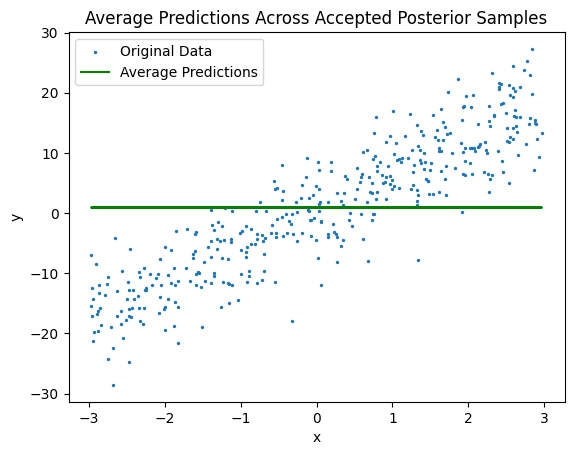

In [145]:
x_data_with_bias = np.concatenate((x_data, np.ones(x_data.shape)), axis=1)
predictions = np.matmul(mcmc.pos_θ, x_data_with_bias.T)
avg_predictions = np.mean(predictions, axis=0)

plt.scatter(x_data, y_data, s=2, label='Original Data')
plt.plot(x_data, avg_predictions, color='green', label='Average Predictions')
plt.title('Average Predictions Across Accepted Posterior Samples')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Plotting the model's simulated outputs with the predicted outputs across all MCMC proposals
Gathering the predictions and simulations (i.e. predicted and simulated outputs across proposed posterior samples) into usable variables...

In [87]:
pred_y = pred['train_pred']
sim_y = pred['train_sim']
pred_y_test = pred['test_pred']
sim_y_test = pred['test_sim']

Averaging the model predictions and simulations...

In [140]:
avg_predictions = np.mean(pred_y, axis=0)
avg_simulations = np.mean(sim_y, axis=0)

Plotting the average predictions and simulations against the original data...

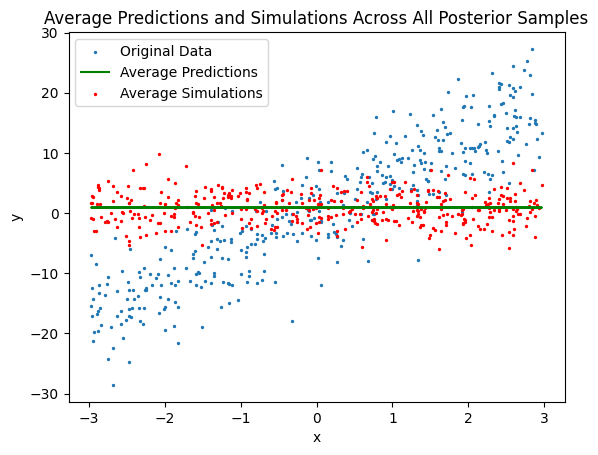

In [144]:
plt.scatter(x_data, y_data, s=2, label='Original Data')
plt.plot(x_data, avg_predictions, color='green', label='Average Predictions')
plt.scatter(x_data, avg_simulations, s=2, color='red', label='Average Simulations')
plt.title('Average Predictions and Simulations Across All Posterior Samples')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()